In [5]:
import json
from os import makedirs
from os.path import basename, dirname, exists, join, realpath
import numpy as np
import matplotlib.pyplot as plt
import sys

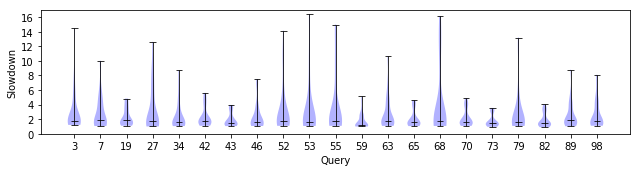

In [6]:

scenarios = ["A", "B", "C", "D", "E", "F", "G", "H"]
runtimes = dict()
nolimit = dict()
nolimit_medians = dict()

filedir = realpath("./")
inputdir = realpath(join(filedir, '../data/fig12/'))


def load_json(runtime_dict, json_strings):
	for string in json_strings:
		crnt_json = json.loads(string)
		crnt_query = crnt_json["name"].split("-")[0]
		crnt_query = crnt_query.split("q")[1]

		if crnt_query == "SsMax":
			continue
		else:
			crnt_query = int(crnt_query)

		if not (crnt_query in runtime_dict):
			runtime_dict[crnt_query] = []
		for val in crnt_json["runtimes"]:
			runtime_dict[crnt_query].append(val)


def load_data():
	for scenario in scenarios:
		crnt_scenario = join(inputdir, scenario + ".json")
		crnt_file = open(crnt_scenario)
		lines = crnt_file.readlines()
		lines = [line.strip() for line in lines]
		crnt_file.close()
		load_json(runtimes, lines)

	nolimit_fn = join(inputdir, "no_limit.json")
	nolimit_file = open(nolimit_fn)
	lines = nolimit_file.readlines()
	lines = [line.strip() for line in lines]
	nolimit_file.close()
	load_json(nolimit, lines)


def get_95th_perc(arr):
	perc = np.percentile(arr, 99)
	ret_arr = [x for x in arr if x < perc]
	return ret_arr


def get_statistics(values, message):
	print("==============    " + message + "   ============")
	result = dict()
	result["avg"] = np.mean(values)
	result["std"] = np.std(values)
	result["npoints"] = len(values)
	result["99th"] = np.percentile(values, 99)
	result["75th"] = np.percentile(values, 75)
	result["50th"] = np.percentile(values, 50)
	result["25th"] = np.percentile(values, 25)
	result["1st"] = np.percentile(values, 1)
	result["CoV"] = result["std"] / result["avg"]
	result["min"] = np.min(values)
	result["max"] = np.max(values)
	print(result)
	print("================================")

	return result


load_data()

for key in nolimit.keys():
	nolimit_medians[key] = np.median(nolimit[key])

keys = runtimes.keys()
runtime_values = []

for key in sorted(keys):
	val = runtimes[key]
	#print("val = " + str(val))
	runtime_values.append(get_95th_perc(val / nolimit_medians[key]))

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (9, 2.5))
vp = ax.violinplot(runtime_values, np.arange(0, len(keys)), showmedians=True, widths=0.5)

partnames =  ["cbars", "cmins", "cmaxes", "cmedians"]

for partname in partnames:
	part = vp[partname]
	part.set_edgecolor("black")
	part.set_linewidth(0.8)

for pc in vp['bodies']:
	pc.set_facecolor("blue")
	pc.set_alpha(0.3)

ax.set_xticks([])
plt.xticks(np.arange(0, len(keys)), [str(x) for x in sorted(keys)])

ax.set_ylim(0, 17)
ax.set_xlabel("Query")
ax.set_ylabel("Slowdown")
ax.set_yticks(np.arange(0, 17, 2))

plt.tight_layout()

plt.show()
